### UPSC Essay Evaluation Assistant

#### Nodes
The assistant is composed of three main nodes:
1.  **Analysis Node**: Analyzes the essay and provides overall feedback.
2.  **Evaluate LANGUAGE Node**: Evaluates the language quality of the essay.
3.  **Evaluate Thought Process Node**: Evaluates the thought process and content quality of the essay.
4. **Summary Node**: Merges the outputs from the evaluation nodes and provides a consolidated feedback report.

#### Topics for Practice
The following concepts will be used in this example:
-   **Reducers**: Merge multiple outputs into a single value. Without a reducer, subsequent outputs would replace previous ones.
-   **Structured Output**: Ensuring the output from the models conforms to a specific schema.
-   **Parallel Workflows**: Executing multiple tasks concurrently and returning partial results as they become available.

In [2]:
!pip install langgraph langchain_google_genai
# standards imports 
import os
from typing import TypedDict, Annotated
from dotenv import load_dotenv
import operator

# third-party imports
from pydantic import BaseModel, Field
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [9]:
load_dotenv()

True

In [11]:
gemini_model = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash"
)

E0000 00:00:1763883007.073222  314191 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


In [12]:
# structured output class
# this is for the model which means how the model will return the output
class EvaluationSchema(BaseModel):
    
    feedback : str = Field(description="Detrailed Feedback for the essay")
    score    : int = Field(description="Score out of 10", ge=0, le=10)
    
structured_model = gemini_model.with_structured_output(EvaluationSchema)

In [13]:
# this is for the langgraph or graph components not for the model
class UPSCState(TypedDict):
    essay : str
    language_feedback : str
    analysis_feedback : str
    thought_feedback : str
    overall_feedback : str
    individual_score : Annotated[list[int], operator.add]
    avg_score : float

In [15]:
# Define evaluation prompts for each evaluation dimension
# Each prompt instructs the model to act as an expert UPSC evaluator

# Language evaluation: Focuses on grammar, vocabulary, syntax, and clarity
language_prompt = """You are an expert Union Public Service Commission (UPSC) Essay evaluator invigilator. 
You have over 10+ Years of Experience (YOE). Your task is to evaluate the following essay on the basis of 
language quality including grammar, vocabulary, sentence structure, clarity, and coherence. 
Rate the essay on a scale of 10.

Essay: {essay}
"""

# Thought process evaluation: Focuses on logical flow, critical thinking, and argumentation
thought_prompt = """You are an expert Union Public Service Commission (UPSC) Essay evaluator invigilator. 
You have over 10+ Years of Experience (YOE). Your task is to evaluate the following essay on the basis of 
thought process, including logical reasoning, critical thinking, depth of analysis, and coherence of arguments. 
Rate the essay on a scale of 10.

Essay: {essay}
"""

# Analysis evaluation: Focuses on content quality, examples, and insights
analysis_prompt = """You are an expert Union Public Service Commission (UPSC) Essay evaluator invigilator. 
You have over 10+ Years of Experience (YOE). Your task is to evaluate the following essay on the basis of 
analytical depth, quality of examples, real-world applications, and insightful observations. 
Rate the essay on a scale of 10.

Essay: {essay}
"""


def language_evaluation(state: UPSCState):
    """
    Evaluates the language quality of the essay.
    
    Args:
        state (UPSCState): Current state containing the essay
        
    Returns:
        dict: Updated state with language feedback and score
    """
    # Format the prompt with the essay text
    prompt = language_prompt.format(essay=state["essay"])
    
    # Invoke the structured model to get evaluation
    output = structured_model.invoke(prompt)
    
    # Return the feedback and append score to individual_score list
    return {
        "language_feedback": output.feedback,
        "individual_score": [output.score]
    }


def thought_evaluation(state: UPSCState):
    """
    Evaluates the thought process and logical reasoning in the essay.
    
    Args:
        state (UPSCState): Current state containing the essay
        
    Returns:
        dict: Updated state with thought process feedback and score
    """
    # Format the prompt with the essay text
    prompt = thought_prompt.format(essay=state["essay"])
    
    # Invoke the structured model to get evaluation
    output = structured_model.invoke(prompt)
    
    # Return the feedback and append score to individual_score list
    return {
        "thought_feedback": output.feedback,
        "individual_score": [output.score]
    }


def analysis_evaluation(state: UPSCState):
    """
    Evaluates the analytical depth and quality of content in the essay.
    
    Args:
        state (UPSCState): Current state containing the essay
        
    Returns:
        dict: Updated state with analysis feedback and score
    """
    # Format the prompt with the essay text
    prompt = analysis_prompt.format(essay=state["essay"])
    
    # Invoke the structured model to get evaluation
    output = structured_model.invoke(prompt)
    
    # Return the feedback and append score to individual_score list
    return {
        "analysis_feedback": output.feedback,
        "individual_score": [output.score]
    }


def final_evaluation(state: UPSCState):
    """
    Consolidates all individual evaluations and computes the average score.
    
    Args:
        state (UPSCState): Current state with all feedback and scores
        
    Returns:
        dict: Updated state with overall feedback and average score
    """
    # Calculate average score from all individual scores
    avg_score = sum(state["individual_score"]) / len(state["individual_score"])
    
    # Compile overall feedback by combining all individual feedback
    overall_feedback = f"""
=== UPSC ESSAY EVALUATION REPORT ===

LANGUAGE EVALUATION:
{state['language_feedback']}

THOUGHT PROCESS EVALUATION:
{state['thought_feedback']}

ANALYTICAL EVALUATION:
{state['analysis_feedback']}

FINAL AVERAGE SCORE: {avg_score:.2f}/10
"""
    
    # Return the consolidated results
    return {
        "overall_feedback": overall_feedback,
        "avg_score": avg_score
    }


In [17]:
# Create the StateGraph with UPSCState as the state schema
graph = StateGraph(UPSCState)


# Add nodes to the graph
# Each node is identified by a string name and associated with its function
graph.add_node('thought_evaluation', thought_evaluation)
graph.add_node('analysis_evaluation', analysis_evaluation)
graph.add_node('language_evaluation', language_evaluation)
graph.add_node('final_evaluation', final_evaluation)

# Define the graph structure with edges
# Level 0: START node branches to three parallel evaluation nodes
# Level 1: Three evaluation nodes run in parallel
graph.add_edge(START, 'language_evaluation')
graph.add_edge(START, 'analysis_evaluation')
graph.add_edge(START, 'thought_evaluation')

# Level 2: All three evaluations converge to final_evaluation node
graph.add_edge('language_evaluation', 'final_evaluation')
graph.add_edge('analysis_evaluation', 'final_evaluation')
graph.add_edge('thought_evaluation', 'final_evaluation')

# Level 3: Final evaluation connects to END
graph.add_edge('final_evaluation', END)

# Compile the graph to create the runnable workflow
compiled_graph = graph.compile()


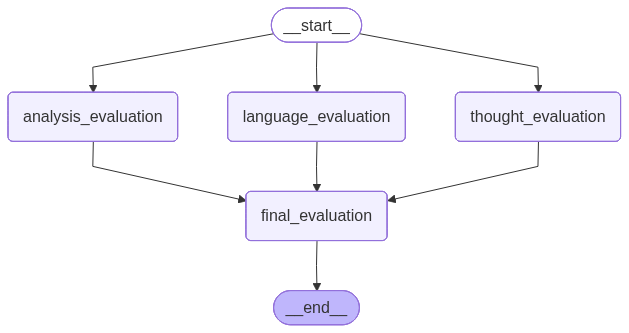

In [18]:
compiled_graph

In [19]:
essay1 = """India and AI Time

Now world change very fast because new tech call Artificial Intel… something (AI). India also want become big in this AI thing. If work hard, India can go top. But if no careful, India go back.

India have many good. We have smart student, many engine-ear, and good IT peoples. Big company like TCS, Infosys, Wipro already use AI. Government also do program “AI for All”. It want AI in farm, doctor place, school and transport.

In farm, AI help farmer know when to put seed, when rain come, how stop bug. In health, AI help doctor see sick early. In school, AI help student learn good. Government office use AI to find bad people and work fast.

But problem come also. First is many villager no have phone or internet. So AI not help them. Second, many people lose job because AI and machine do work. Poor people get more bad.

One more big problem is privacy. AI need big big data. Who take care? India still make data rule. If no strong rule, AI do bad.

India must all people together – govern, school, company and normal people. We teach AI and make sure AI not bad. Also talk to other country and learn from them.

If India use AI good way, we become strong, help poor and make better life. But if only rich use AI, and poor no get, then big bad thing happen.

So, in short, AI time in India have many hope and many danger. We must go right road. AI must help all people, not only some. Then India grow big and world say "good job India"."""

In [20]:
initial_state = {
    'essay' : essay1
}

compiled_graph.invoke(initial_state)

{'essay': 'India and AI Time\n\nNow world change very fast because new tech call Artificial Intel… something (AI). India also want become big in this AI thing. If work hard, India can go top. But if no careful, India go back.\n\nIndia have many good. We have smart student, many engine-ear, and good IT peoples. Big company like TCS, Infosys, Wipro already use AI. Government also do program “AI for All”. It want AI in farm, doctor place, school and transport.\n\nIn farm, AI help farmer know when to put seed, when rain come, how stop bug. In health, AI help doctor see sick early. In school, AI help student learn good. Government office use AI to find bad people and work fast.\n\nBut problem come also. First is many villager no have phone or internet. So AI not help them. Second, many people lose job because AI and machine do work. Poor people get more bad.\n\nOne more big problem is privacy. AI need big big data. Who take care? India still make data rule. If no strong rule, AI do bad.\n\n